In [2]:
!pip install pandas
!pip install numpy
import pandas as pd
import numpy as np  
import os

!pip install seaborn
import seaborn as sns

from pandas.api.types import CategoricalDtype
Train_label = pd.read_csv('Training set labels.csv')
Train_value = pd.read_csv('Training set values.csv')
Test_value = pd.read_csv('Test set values.csv')
Train = pd.merge(Train_value,Train_label, how='inner',left_on='id',right_on='id', left_index=False)

In [ ]:
Train.shape

In [ ]:
Train.head()

In [ ]:
Train.isnull().sum()

In [3]:
Train[['longitude','latitude']].describe()

,longitude,latitude
count,59400.000000,5.940000e+04
mean,34.077427,-5.706033e+00
std,6.567432,2.946019e+00
min,0.000000,-1.164944e+01
25%,33.090347,-8.540621e+00
50%,34.908743,-5.021597e+00
75%,37.178387,-3.326156e+00
max,40.345193,-2.000000e-08


In [2]:
# Reference: https://worldpopulationreview.com/country-locations/where-is-tanzania    
# Range of Most Extreme Points in Every Direction of Tanzania
# latitude :  00°59' - 11°45′ -> should be negative due South Lat  -> -0.59  ~ - 11.45
# longitude:  29°10' -  40°29′ East
long_lat_error =Train[((Train['longitude'] < 29.10)  | (Train['longitude'] > 40.29)) | ((Train['latitude'] < -11.45)  | (Train['latitude'] > -0.59))] 
long_lat_error

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
21,6091,0.0,2013-02-10,Dwsp,0,DWE,0.000000,-2.000000e-08,Muungano,0,...,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump,functional
53,32376,0.0,2011-08-01,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,Polisi,0,...,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
168,72678,0.0,2013-01-30,Wvt,0,WVT,0.000000,-2.000000e-08,Wvt Tanzania,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
177,56725,0.0,2013-01-17,Netherlands,0,DWE,0.000000,-2.000000e-08,Kikundi Cha Wakina Mama,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
253,13042,0.0,2012-10-29,Hesawa,0,DWE,0.000000,-2.000000e-08,Kwakisusi,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59208,3631,0.0,2013-01-22,Dwsp,0,DWE,0.000000,-2.000000e-08,Mtakuja,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59295,60843,0.0,2011-07-19,Rwssp,0,DWE,0.000000,-2.000000e-08,Maendeleo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
59322,44114,6000.0,2013-02-14,Unicef,532,UNICEF,36.985457,-1.146723e+01,Misepelo,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional needs repair
59324,748,0.0,2013-01-22,World Vision,0,World Vision,0.000000,-2.000000e-08,Mwazwilo,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [3]:
# Correct long_lat_error using mean long & lat
long_mean = Train[(Train['longitude'] >= 29.10)  | (Train['longitude'] <= 40.29)]['longitude'].mean()
lat_mean = Train[(Train['latitude'] >= -11.45)  | (Train['latitude'] <= -0.59)]['latitude'].mean()
#long_mean: 34.077426692028794
#lat_mean: -5.706032659626431
                  

In [4]:
Train['longitude'] = np.where(((Train.longitude <29.10 ) | (Train.longitude > 40.29)),long_mean,Train.longitude)
Train['latitude'] = np.where(((Train.latitude < -11.45) | (Train.latitude > -0.59)),lat_mean,Train.latitude)

In [5]:
# Test long_lat_error -> should be zero instance 
long_lat_error =Train[((Train['longitude'] < 29.10)  | (Train['longitude'] > 40.29)) | ((Train['latitude'] < -11.45)  | (Train['latitude'] > -0.59))] 
long_lat_error # zero instance
Train[['longitude','latitude']].describe()

,longitude,latitude
count,59400.000000,59400.000000
mean,35.114020,-5.871996
std,2.571584,2.758860
min,29.607122,-11.449849
25%,33.354079,-8.524319
50%,34.905440,-5.440285
75%,37.173618,-3.398151
max,40.287471,-0.998464


In [8]:
df_long_lat = Train[['longitude','latitude','status_group']]
df_long_lat.to_csv("long_lat_status.csv")

In [2]:
df = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)
df

region_code,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,24,40,60,80,90,99
region,,,,,,,,,,,,,,,,,,,,,
Arusha,0,3024,0,0,0,0,0,0,0,0,...,0,0,0,0,326,0,0,0,0,0
Dar es Salaam,0,0,0,0,0,0,805,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dodoma,2201,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Iringa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kagera,0,0,0,0,0,0,0,0,0,0,...,3316,0,0,0,0,0,0,0,0,0
Kigoma,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kilimanjaro,0,0,4379,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lindi,0,0,0,0,0,0,0,300,0,0,...,8,0,0,0,0,0,0,1238,0,0
Manyara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1583,0,0,0,0,0,0


In [4]:
#Standerdize region code with region
#Reference: https://www.citypopulation.de/en/tanzania/admin/
df = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)
df.to_csv('region_error.csv')
Train.loc[Train['region_code'] == 24,'region_code'] = 2
Train.loc[(Train['region_code'] == 18 )| (Train['region_code'] == 80),'region_code' ] = 8
Train.loc[(Train['region_code'] == 90 )| (Train['region_code'] == 99),'region_code' ] = 9
Train.loc[(Train['region_code'] == 17) & (Train['region'] == 'Mwanza'),'region_code'] = 19
Train.loc[(Train['region_code'] == 60 )| (Train['region_code'] == 40),'region_code'] = 6
Train.loc[(Train['region_code'] == 5)  & (Train['region'] == 'Tanga') ,'region_code' ] = 4
Train.loc[(Train['region_code'] == 11) & (Train['region'] == 'Shinyanga'),'region_code'] = 17
Train.loc[(Train['region_code'] == 14 )& (Train['region'] == 'Shinyanga'),'region_code'] = 17

df = Train.pivot_table('id','region','region_code',aggfunc='count').fillna(0).astype(int)
df
                                    
                                    
                                

region_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20,21
region,,,,,,,,,,,,,,,,,,,,
Arusha,0,3350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dar es Salaam,0,0,0,0,0,0,805,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,2201,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,0,0,0,0,0,0,0,0,0,0,5294,0,0,0,0,0,0,0,0,0
Kagera,0,0,0,0,0,0,0,3316,0,0,0,0,0,0,0,0,0,0,0,0
Kigoma,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2816,0,0,0,0
Kilimanjaro,0,0,4379,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,0,0,0,0,0,0,0,1546,0,0,0,0,0,0,0,0,0,0,0,0
Manyara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1583


In [3]:
df_region = Train.pivot_table('id','region','status_group',aggfunc='count')
df_region.to_csv('reg_status.csv')

In [6]:
Train['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [19]:
df_district = Train.pivot_table('id','region','district_code',aggfunc='count').fillna(0).astype(int)
# district_code with 0 -> error   
df_district


district_code,0,1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67,80
region,,,,,,,,,,,,,,,,,,,,
Arusha,0,189,1206,109,0,201,310,1009,0,0,0,326,0,0,0,0,0,0,0,0
Dar es Salaam,0,93,497,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,23,888,0,361,347,358,224,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,0,728,530,650,2473,564,0,349,0,0,0,0,0,0,0,0,0,0,0,0
Kagera,0,771,487,402,403,0,88,260,236,0,0,669,0,0,0,0,0,0,0,0
Kigoma,0,874,1159,727,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kilimanjaro,0,595,519,877,1225,620,109,434,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,0,1,7,300,0,0,0,0,0,391,293,0,0,154,291,0,109,0,0,0
Manyara,0,550,274,297,276,186,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
Train.loc[Train['district_code'] == 0,'district_code'] = 1
df_district = Train.pivot_table('id','region','district_code',aggfunc='count').fillna(0).astype(int) 
df_district

district_code,1,2,3,4,5,6,7,8,13,23,30,33,43,53,60,62,63,67,80
region,,,,,,,,,,,,,,,,,,,
Arusha,189,1206,109,0,201,310,1009,0,0,0,326,0,0,0,0,0,0,0,0
Dar es Salaam,93,497,215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Dodoma,911,0,361,347,358,224,0,0,0,0,0,0,0,0,0,0,0,0,0
Iringa,728,530,650,2473,564,0,349,0,0,0,0,0,0,0,0,0,0,0,0
Kagera,771,487,402,403,0,88,260,236,0,0,669,0,0,0,0,0,0,0,0
Kigoma,874,1159,727,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Kilimanjaro,595,519,877,1225,620,109,434,0,0,0,0,0,0,0,0,0,0,0,0
Lindi,1,7,300,0,0,0,0,0,391,293,0,0,154,291,0,109,0,0,0
Manyara,550,274,297,276,186,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
Train['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [3]:
Train['population'].describe()
Train['population']

0        109
1        280
2        250
3         58
4          0
        ... 
59395    125
59396     56
59397      0
59398      0
59399    150
Name: population, Length: 59400, dtype: int64

<AxesSubplot:xlabel='population', ylabel='Density'>

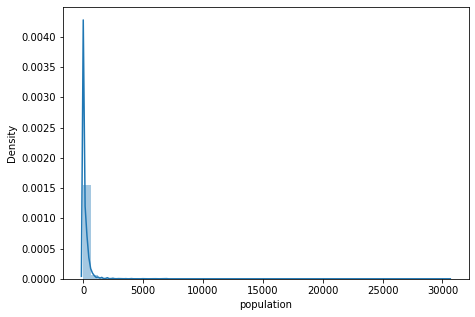

In [6]:
Train[Train['population'] == 0]  # 21381 records  => zero population
#https://worldpopulationreview.com/countries/tanzania-population
#https://www.analyticsvidhya.com/blog/2021/05/feature-engineering-how-to-detect-and-remove-outliers-with-python-code/
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(Train['population']) # left skewed 

<AxesSubplot:xlabel='population'>

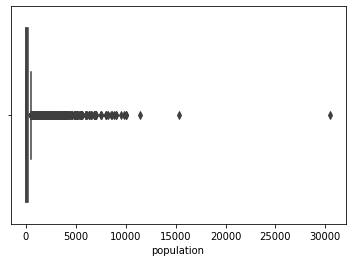

In [7]:
sns.boxplot(Train['population'])

In [14]:
Train[['region','population']]
df_pop = Train.pivot_table('id','region','population',aggfunc='sum').fillna(0).astype(int) 
df_pop['sum'] = df_pop.sum(axis = 1)
df_pop['sum']

region
Arusha           125452610
Dar es Salaam     30017353
Dodoma            80760619
Iringa           194159068
Kagera           123713407
Kigoma           102667532
Kilimanjaro      163126393
Lindi             57574121
Manyara           59102904
Mara              74861850
Mbeya            174055235
Morogoro         148280588
Mtwara            63791546
Mwanza           116488810
Pwani             97304169
Rukwa             67564706
Ruvuma            99180138
Shinyanga        182679138
Singida           76474025
Tabora            72555411
Tanga             94829204
Name: sum, dtype: int64

In [5]:
Train["lga"].value_counts() #125
df_lga = Train[["region","lga","status_group"]]
df_lga['status_cat'] = df_lga['status_group'].astype('category')
df_lga['status_group'] = df_lga['status_group'].astype('category')
df_lga.info()
df_lga.info()
df_lga['status_cat']= df_lga['status_group'].cat.codes
df_lga = df_lga.pivot_table(df_lga, index = ['region','lga'], columns = 'status_group',aggfunc= 'count' )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   region        59400 non-null  object  
 1   lga           59400 non-null  object  
 2   status_group  59400 non-null  category
 3   status_cat    59400 non-null  category
dtypes: category(2), object(2)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   region        59400 non-null  object  
 1   lga           59400 non-null  object  
 2   status_group  59400 non-null  category
 3   status_cat    59400 non-null  category
dtypes: category(2), object(2)
memory usage: 1.5+ MB


/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [6]:
df_lga



status_cat                                       
status_group        functional functional needs repair non functional
region lga                                                           
Arusha Arusha Rural        875                      48            329
       Arusha Urban         42                       7             14
       Babati                0                       0              0
       Bagamoyo              0                       0              0
       Bahi                  0                       0              0
...                        ...                     ...            ...
Tanga  Tunduru               0                       0              0
       Ukerewe               0                       0              0
       Ulanga                0                       0              0
       Urambo                0                       0              0
       Uyui                  0                       0              0

[2625 rows x 3 columns]

In [9]:
df_lga.loc[Train["lga"].str.contains(("Rural" or "Urban"), case=False)]["lga"] #9552
#df_lga.loc[Train["lga"].str.contains("Urban", case=False)]["lga"] #1683




IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
# Function to set up # of category for features
test_cat = 8
def max_cat(col):
    if len(Train[col].value_counts()) > (test_cat):
        top_value = Train[col].value_counts()[:(test_cat)].index.tolist()
        Train.loc[-Train[col].isin(top_value),col]='Others'
                
    return Train
        
        

In [ ]:
max_cat('region')
Train[Train['region'] =='Others']

In [6]:
Train['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
2     3350
18    3324
19    3047
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
8      300
40       1
Name: region_code, dtype: int64

In [32]:
Train['district_code'].value_counts()
#region_code 
#district_code 
#lga 
#ward 
#population 

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64